# Use Adam till convergence point then use SGDM

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

# import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Import dataset

In [2]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [4]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst = []
    loss_lst = []
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        start_time = time.time()
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst.append((correct/num_labels).cpu().item())
        loss_lst.append(total_loss/counter)

        end_time = time.time()

        # wandb.log({'Accuracy': accuracy_lst[-1], 'Loss': loss_lst[-1]})

        print('Epoch %d, Loss %4f, Accuracy %4f, finished in %.4f seconds' % (epoch+1, total_loss/counter, correct/num_labels, end_time-start_time))
    
    return accuracy_lst, loss_lst

In [5]:
def evaluate(model, test_loader, loss_func):
    total_loss = 0
    correct = 0
    num_labels = 0
    counter = 0
    model.eval()
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        loss = loss_func(output, y)
        total_loss += loss.item()

        predicted = torch.max(output,1)[1]
        correct += (predicted == y).sum()
        num_labels += len(y)
        counter += 1
    print('Test Loss %4f, Test Accuracy %4f' % (total_loss/counter, correct/num_labels))

## Training

In [6]:
lr = 0.01

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)


### SGDM

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)

accuracy_lst_SGD, loss_lst_SGD = train(model, train_loader, optimizer, loss_func, 20)
evaluate(model, test_loader, loss_func)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 1.842859, Accuracy 0.382420, finished in 20.8118 seconds


Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.361318, Accuracy 0.513120, finished in 14.6705 seconds


Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.204617, Accuracy 0.574900, finished in 15.1673 seconds


Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.117279, Accuracy 0.608980, finished in 14.3804 seconds


Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.051421, Accuracy 0.631380, finished in 14.1619 seconds


Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 1.006312, Accuracy 0.649060, finished in 14.2019 seconds


Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.955475, Accuracy 0.668780, finished in 15.5531 seconds


Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.916813, Accuracy 0.682600, finished in 14.3944 seconds


Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.898196, Accuracy 0.689980, finished in 14.2657 seconds


Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.864257, Accuracy 0.701860, finished in 16.1161 seconds


Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.838350, Accuracy 0.712340, finished in 14.3715 seconds


Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.826285, Accuracy 0.715260, finished in 14.1719 seconds


Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.811979, Accuracy 0.720540, finished in 14.1681 seconds


Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.788549, Accuracy 0.726900, finished in 14.1294 seconds


Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.787657, Accuracy 0.726660, finished in 14.4943 seconds


Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.772382, Accuracy 0.733900, finished in 14.3357 seconds


Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.760443, Accuracy 0.736600, finished in 14.0462 seconds


Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.751614, Accuracy 0.741080, finished in 13.9468 seconds


Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.744953, Accuracy 0.743580, finished in 13.9638 seconds


Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.730971, Accuracy 0.749140, finished in 14.0985 seconds
Test Loss 1.167372, Test Accuracy 0.637000


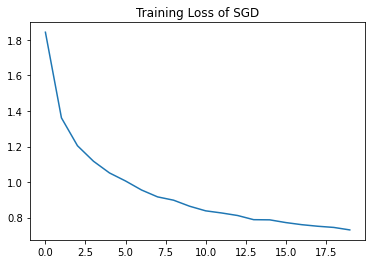

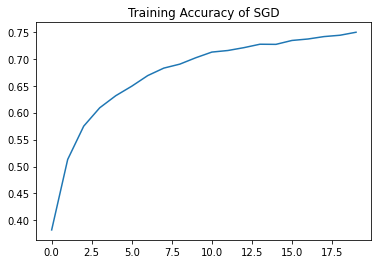

In [8]:
plt.plot(range(20), loss_lst_SGD)
plt.title('Training Loss of SGD')
plt.show()

plt.plot(range(20), accuracy_lst_SGD)
plt.title('Training Accuracy of SGD')
plt.show()

### Adam

In [9]:
# Adam
# Adam_run = wandb.init(project="CSI 5340 Project", entity="kwang126", name='Adam')
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)

accuracy_lst_Adam, loss_lst_Adam = train(model, train_loader, optimizer, loss_func, 20)
evaluate(model, test_loader, loss_func)
# Adam_run.finish()

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 1.194335, Accuracy 0.600360, finished in 15.8632 seconds


Epoch 2/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 0.969735, Accuracy 0.666160, finished in 14.3446 seconds


Epoch 3/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 0.930581, Accuracy 0.678040, finished in 14.2712 seconds


Epoch 4/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.917050, Accuracy 0.681820, finished in 14.2589 seconds


Epoch 5/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.911776, Accuracy 0.683740, finished in 14.4521 seconds


Epoch 6/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.907483, Accuracy 0.685140, finished in 14.4575 seconds


Epoch 7/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.897920, Accuracy 0.691900, finished in 14.4063 seconds


Epoch 8/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.897823, Accuracy 0.690760, finished in 14.3001 seconds


Epoch 9/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.889830, Accuracy 0.693760, finished in 14.4177 seconds


Epoch 10/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.890762, Accuracy 0.692700, finished in 14.2822 seconds


Epoch 11/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.887363, Accuracy 0.693500, finished in 14.3445 seconds


Epoch 12/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.881781, Accuracy 0.696760, finished in 14.3574 seconds


Epoch 13/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.884641, Accuracy 0.695940, finished in 14.4377 seconds


Epoch 14/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.883187, Accuracy 0.695780, finished in 14.3321 seconds


Epoch 15/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.888677, Accuracy 0.694440, finished in 16.0259 seconds


Epoch 16/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.886733, Accuracy 0.693340, finished in 14.4688 seconds


Epoch 17/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.888478, Accuracy 0.695000, finished in 14.5409 seconds


Epoch 18/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.878064, Accuracy 0.697220, finished in 14.4042 seconds


Epoch 19/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.878843, Accuracy 0.696460, finished in 14.2677 seconds


Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.887974, Accuracy 0.694180, finished in 14.1977 seconds
Test Loss 1.426982, Test Accuracy 0.579800


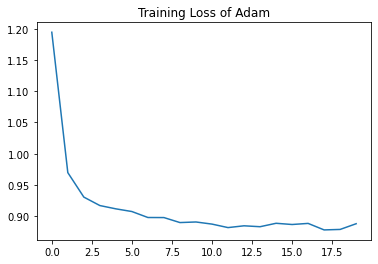

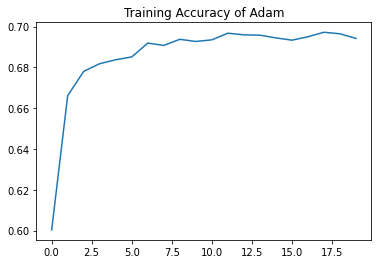

In [10]:
plt.plot(range(20), loss_lst_Adam)
plt.title('Training Loss of Adam')
plt.show()

plt.plot(range(20), accuracy_lst_Adam)
plt.title('Training Accuracy of Adam')
plt.show()